In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

import gensim

import scikitplot.plotters as skplt

import nltk

from xgboost import XGBClassifier

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.optimizers import Adam

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("E:/Python/Project/all"))

# Any results you write to the current directory are saved as output.

C:\Users\Ashish\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
C:\Users\Ashish\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
C:\Users\Ashish\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


['stage1_solution_filtered.csv.7z', 'stage2_sample_submission.csv.7z', 'stage2_test_text.csv.7z', 'stage2_test_variants.csv.7z', 'stage_2_private_solution.csv.7z', 'test_text', 'test_text.zip', 'test_variants', 'test_variants.zip', 'training_text', 'training_text.zip', 'training_variants', 'training_variants.zip']


In [2]:
train_variants = pd.read_csv("E:/Python/Project/all/training_variants")
train_variants.head(8)


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4
5,5,CBL,V391I,4
6,6,CBL,V430M,5
7,7,CBL,Deletion,1


In [3]:
test_variants = pd.read_csv("E:/Python/Project/all/test_variants")
test_variants.head(8)


,ID,Gene,Variation
0,0,ACSL4,R570S
1,1,NAGLU,P521L
2,2,PAH,L333F
3,3,ING1,A148D
4,4,TMEM216,G77A
5,5,CD40LG,A123E
6,6,KLF11,T220M
7,7,SGCB,T151R


In [4]:
train_text = pd.read_csv("E:/Python/Project/all/training_text", 
                         sep="\|\|", 
                         engine='python', 
                         header=None, 
                         skiprows=1, 
                         names=["ID","Text"])
test_text = pd.read_csv("E:/Python/Project/all/test_text", 
                        sep="\|\|", 
                        engine='python', 
                        header=None, 
                        skiprows=1, 
                        names=["ID","Text"])
print("Train variants shape : ",train_variants.shape)
print("test variants shape : ",test_variants.shape)
print("Train text shape : ",train_text.shape)
print("test text shape : ",test_text.shape)

Train variants shape :  (3321, 4)
test variants shape :  (5668, 3)
Train text shape :  (3321, 2)
test text shape :  (5668, 2)


In [5]:
# i am interested to read a whole text in a single row of train text file!!!
counter = 0
with open("E:/Python/Project/all/training_text", encoding="utf8") as infile:
    while True:
        counter += 1
        line = infile.readline()
        print(line)
        if counter==2:
            break


ID,Text

0||Cyclin-dependent kinases (CDKs) regulate a variety of fundamental cellular processes. CDK10 stands out as one of the last orphan CDKs for which no activating cyclin has been identified and no kinase activity revealed. Previous work has shown that CDK10 silencing increases ETS2 (v-ets erythroblastosis virus E26 oncogene homolog 2)-driven activation of the MAPK pathway, which confers tamoxifen resistance to breast cancer cells. The precise mechanisms by which CDK10 modulates ETS2 activity, and more generally the functions of CDK10, remain elusive. Here we demonstrate that CDK10 is a cyclin-dependent kinase by identifying cyclin M as an activating cyclin. Cyclin M, an orphan cyclin, is the product of FAM58A, whose mutations cause STAR syndrome, a human developmental anomaly whose features include toe syndactyly, telecanthus, and anogenital and renal malformations. We show that STAR syndrome-associated cyclin M mutants are unable to interact with CDK10. Cyclin M silencing pheno

In [6]:
# lets see the length of each Text row
train_text['word_count'] = train_text['Text'].apply(lambda x: len(str(x).split(" ")))
train_text[['ID','Text','word_count']].head()

,ID,Text,word_count
0,0,Cyclin-dependent kinases (CDKs) regulate a var...,6105
1,1,Abstract Background Non-small cell lung canc...,5783
2,2,Abstract Background Non-small cell lung canc...,5783
3,3,Recent evidence has demonstrated that acquired...,5625
4,4,Oncogenic mutations in the monomeric Casitas B...,6248


C:\Users\Ashish\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


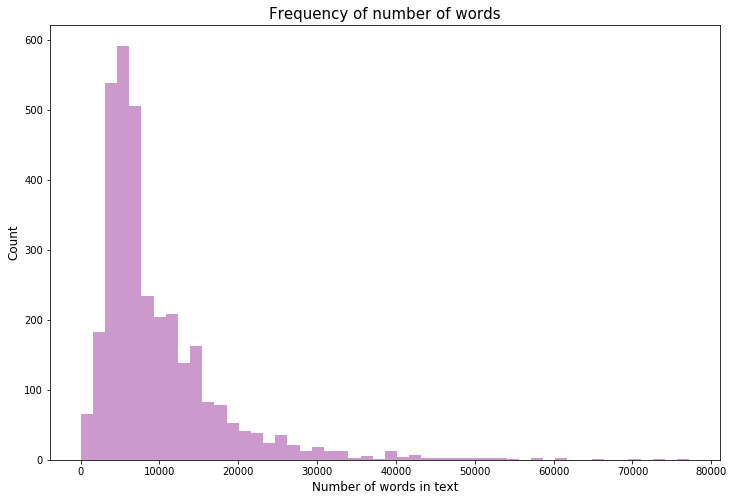

In [31]:
plt.figure(figsize=(12, 8))
sns.distplot(train_text.word_count.values, bins=50, kde=False, color='purple')
plt.xlabel('Number of words in text', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title("Frequency of number of words", fontsize=15)
plt.show()

2 26.89
5 53.03
10 71.59
20 82.95
20 82.95
50 95.08
100 98.11
300 100.0


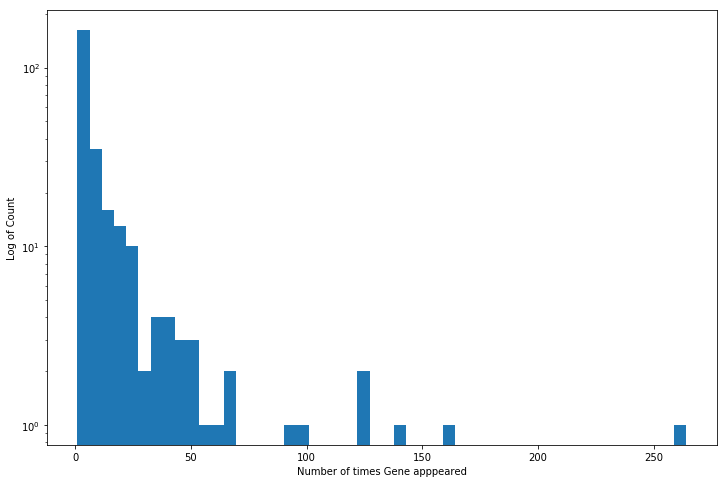

In [54]:
train_genes = train_variants.groupby('Gene')['Gene'].count()

for i in [2,5,10,20,20,50,100,300]:
    print(i, round((train_genes < i).mean()*100, 2))

plt.figure(figsize=(12,8))
plt.hist(train_genes.values, bins = 50, log = True)
plt.xlabel('Number of times Gene apppeared')
plt.ylabel('Log of Count')
plt.show()

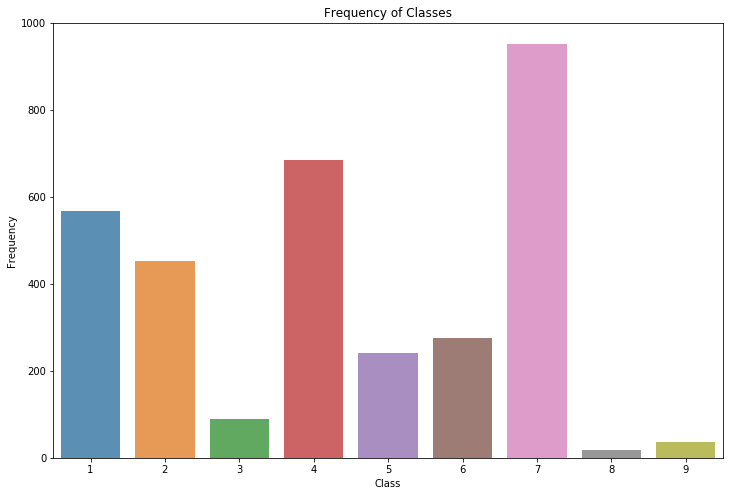

In [8]:

class_df = train_variants.Class.value_counts()
plt.figure(figsize=(12,8))
sns.barplot(class_df.index, class_df.values, alpha=0.8)
plt.ylabel('Frequency')
plt.xlabel('Class')
plt.title('Frequency of Classes')
plt.show()

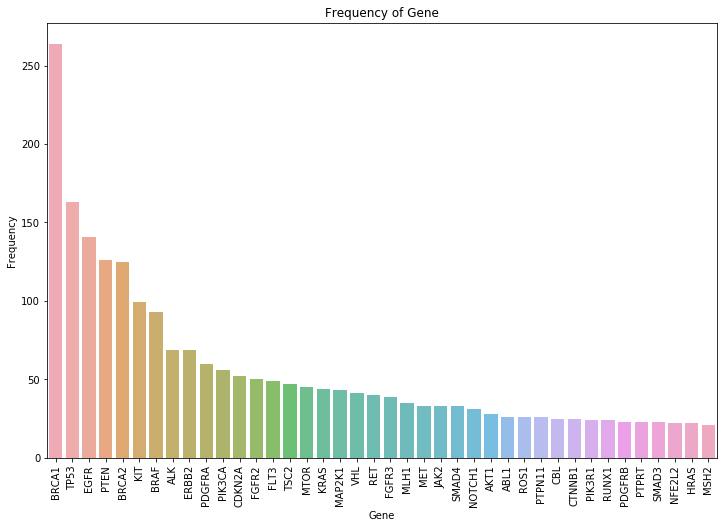

In [9]:
gene_df = train_variants.Gene.value_counts()
gene_df = gene_df.head(40)
plt.figure(figsize=(12,8))
sns.barplot(gene_df.index, gene_df.values, alpha=0.8)

plt.ylabel('Frequency')
plt.xlabel('Gene')
plt.title('Frequency of Gene')
plt.xticks(rotation='vertical')
plt.show()

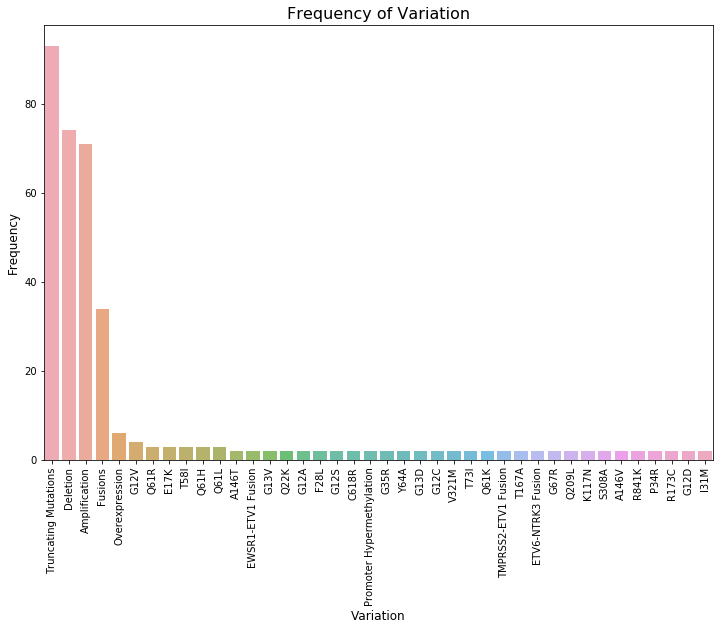

In [10]:
Var_df = train_variants.Variation.value_counts().reset_index()
Var_df = Var_df.head(40)
plt.figure(figsize = (12,8))
sns.barplot(Var_df['index'], Var_df.Variation, alpha=0.8)
plt.ylabel('Frequency', fontsize = 12)
plt.xlabel('Variation', fontsize = 12)
plt.title('Frequency of Variation', fontsize = 16)
plt.xticks(rotation='vertical')
plt.show()

In [11]:
train_variants.ID = train_variants.ID.astype(str)
test_variants.ID = test_variants.ID.astype(str)
train_text.ID = train_text.ID.astype(str)
test_text.ID = test_text.ID.astype(str)

train_full = pd.merge(train_variants, train_text, on='ID')
test_full  = pd.merge(test_variants, test_text, on='ID')

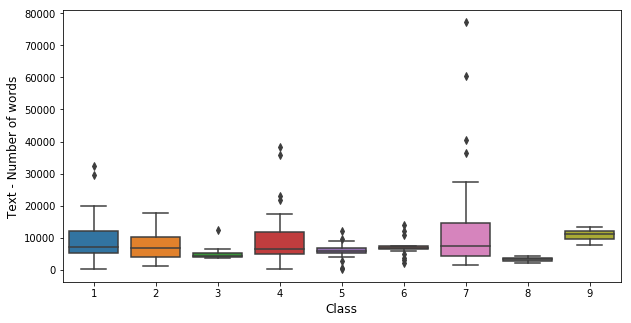

In [60]:
plt.figure(figsize=(10,5))
sns.boxplot(x='Class', y='word_count', data=train_full)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Text - Number of words', fontsize=12)
plt.show()

C:\Users\Ashish\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


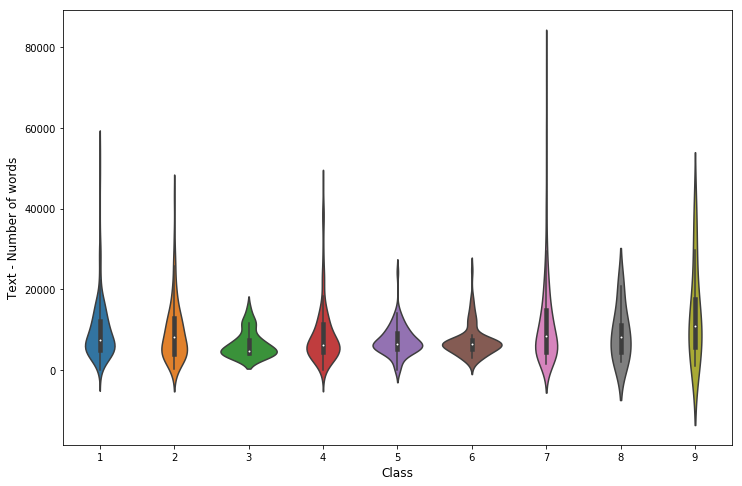

In [37]:
plt.figure(figsize=(12,8))
sns.violinplot(x='Class', y='word_count', data=train_full)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Text - Number of words', fontsize=12)
plt.show()

In [13]:
train_full.describe(include='all')

,ID,Gene,Variation,Class,Text,word_count
count,3321,3321,3321,3321.000000,3316,3321.000000
unique,3321,264,2996,NaN,1920,NaN
top,203,BRCA1,Truncating Mutations,NaN,The PTEN (phosphatase and tensin homolog) phos...,NaN
freq,1,264,93,NaN,53,NaN
mean,NaN,NaN,NaN,4.365854,NaN,9574.389642
std,NaN,NaN,NaN,2.309781,NaN,7890.969431
min,NaN,NaN,NaN,1.000000,NaN,1.000000
25%,NaN,NaN,NaN,2.000000,NaN,4757.000000
50%,NaN,NaN,NaN,4.000000,NaN,6708.000000
75%,NaN,NaN,NaN,7.000000,NaN,12031.000000


In [14]:
test_full.describe(include='all')

,ID,Gene,Variation,Text
count,5668,5668,5668,5667
unique,5668,1397,5628,5610
top,203,F8,Truncating Mutations,The PTEN (phosphatase and tensin homolog) phos...
freq,1,134,18,6


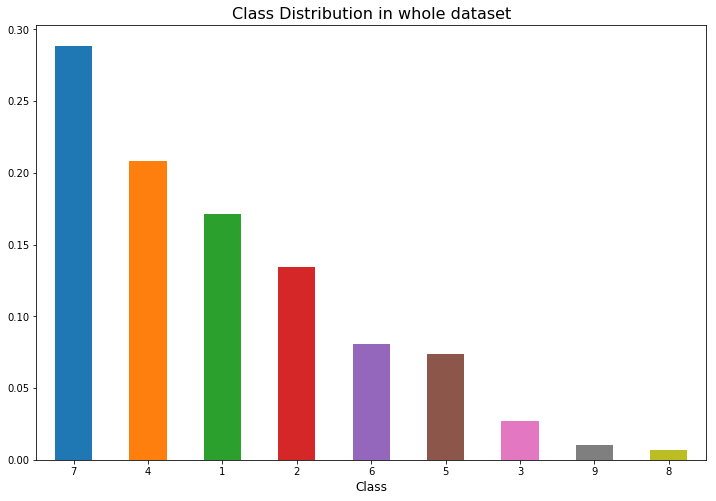

In [66]:
plt.figure(figsize=(12,8))
train_full['Class'].value_counts(normalize = True).plot(kind="bar", rot=0)
plt.xlabel('Class', fontsize=12)
plt.title('Class Distribution in whole dataset', fontsize = 16)
plt.show()

In [38]:
# This cell reduces the training data for Kaggle limits. Remove this cell for real results.
train_full, _ = train_test_split(train_full, test_size=0.7, random_state=8, stratify=train_full['Class'])
train_full.shape
train_full.head()

,ID,Gene,Variation,Class,Text,word_count
2143,2143,KEAP1,G186R,4,NRF2 is a transcription factor that mediates s...,4757
3113,3113,RAD51C,G264S,3,There is strong evidence that overtly inactiva...,12331
2846,2846,BRCA2,R2336H,4,Mutation screening of the breast and ovarian c...,17333
1099,1099,BAP1,A95D,4,BRCA1 associated protein 1 (BAP1) is a nuclear...,17424
1187,1187,PIK3CA,E545K,7,Activation of the phosphoinositide 3-kinase (P...,22454


In [17]:
#Define a helper function to evaluate the effectiveness of transformed free text. 
#We'll use a simple logistic regression 
#with 3-fold stratified cross-validation for fast evaluation.
def feature_eval(X, y, clf=None):
    """General helper function for evaluating effectiveness of passed features in ML model
    
    Prints out Log loss, accuracy, and confusion matrix with 3-fold stratified cross-validation
    
    Args:
        X (array-like): Features array. Shape (n_samples, n_features)
        
        y (array-like): Labels array. Shape (n_samples,)
        
        clf: Classifier to use. If None, default Log reg is use.
    """
    if clf is None:
        clf = LogisticRegression()
    
    probas = cross_val_predict(clf, X, y, cv=StratifiedKFold(random_state=8), 
                              n_jobs=-1, method='predict_proba', verbose=2)
    pred_indices = np.argmax(probas, axis=1)
    classes = np.unique(y)
    preds = classes[pred_indices]
    print('Log loss: {}'.format(log_loss(y, probas)))
    print('Accuracy: {}'.format(accuracy_score(y, preds)))
    skplt.plot_confusion_matrix(y, preds)

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.1s finished
C:\Users\Ashish\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)


Log loss: 0.3453069138000641
Accuracy: 0.9466666666666667


C:\Users\Ashish\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


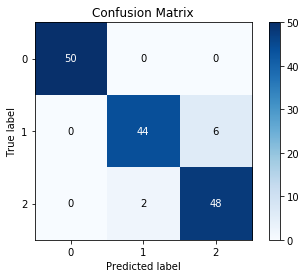

In [18]:
# Quick test of evaluate_features
from sklearn.datasets import load_iris
feature_eval(*load_iris(True))

In [19]:
## Start with a simple baseline. Bag of words
count_vectorizer = CountVectorizer(
    analyzer="word", tokenizer=nltk.word_tokenize,
    preprocessor=None, stop_words='english', max_features=None)

In [20]:
words_bag = count_vectorizer.fit_transform(train_full['Text'])

In [47]:
len(count_vectorizer.get_feature_names())

157293

In [22]:
svd = TruncatedSVD(n_components=25, 
                   n_iter=25, 
                   random_state=12)
truncated_bag_of_words = svd.fit_transform(words_bag)

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.5s finished
C:\Users\Ashish\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)


Log loss: 1.597679035090923
Accuracy: 0.4779116465863454


C:\Users\Ashish\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


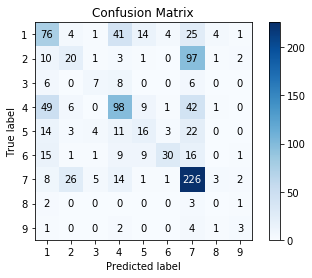

In [23]:
feature_eval(truncated_bag_of_words, train_full['Class'].values.ravel())

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.2s finished
C:\Users\Ashish\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Ashish\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Log loss: 1.4466615380196561
Accuracy: 0.49698795180722893


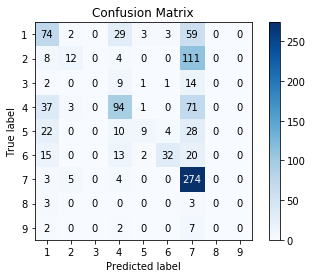

In [24]:
feature_eval(truncated_bag_of_words, train_full['Class'].values.ravel(), 
                  RandomForestClassifier(n_estimators=1000, max_depth=5, verbose=1))

In [25]:
count_vectorizer = TfidfVectorizer(
    analyzer="word", tokenizer=nltk.word_tokenize,
    preprocessor=None, stop_words='english', max_features=None)    

tfidf = count_vectorizer.fit_transform(train_full['Text'])

len(count_vectorizer.get_feature_names())

157293

In [27]:
svd = TruncatedSVD(n_components=25, n_iter=25, random_state=12)
truncated_tfidf = svd.fit_transform(tfidf)

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.0s finished
C:\Users\Ashish\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)


Log loss: 1.51383199181559
Accuracy: 0.4528112449799197


C:\Users\Ashish\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


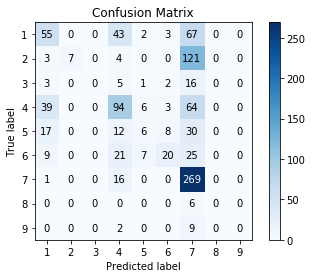

In [28]:
feature_eval(truncated_tfidf, train_full['Class'].values.ravel())

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.9s finished
C:\Users\Ashish\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)


Log loss: 1.3451669501310666
Accuracy: 0.5130522088353414


C:\Users\Ashish\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


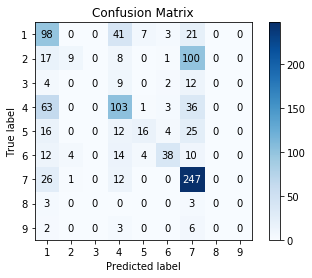

In [29]:
feature_eval(truncated_tfidf, train_full['Class'].values.ravel(), 
                  RandomForestClassifier(n_estimators=1000, max_depth=5, verbose=1))

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.6min finished
C:\Users\Ashish\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)


Log loss: 1.2076654787609804
Accuracy: 0.5552208835341366


C:\Users\Ashish\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


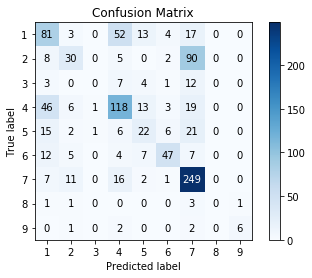

In [30]:
feature_eval(tfidf, train_full['Class'].values.ravel(), 
                  SVC(kernel='linear', probability=True))